In [2]:
import torch
from torch.utils.data import DataLoader, random_split # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt
import random

In [3]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [4]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [5]:
# loading the data
train_size = int(len(train_data) * 0.8)  # 80% of the data for training
val_size = len(train_data) - train_size  # 20% of the data for validation
train_subset, val_subset = random_split(train_data, [train_size, val_size])

train_dataloader = DataLoader(train_subset, batch_size=64) 
val_dataloader = DataLoader(val_subset, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

Name: Coat, Number: 4


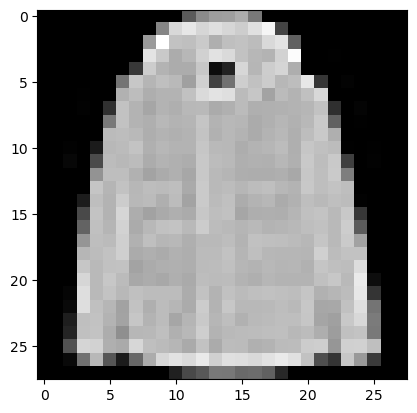

In [6]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [27]:
input1 = torch.randn((64, 1, 28, 28))
w1 = torch.randn((12, 1, 2, 2))


In [192]:
def conv(input, w, stride=1, padding=0):
    batch_size, in_channels, in_height, in_width = input.shape
    out_channels, _, kernel_height, kernel_width = w.shape

    out_height = (in_height - kernel_height + 2 * padding) // stride + 1
    out_width = (in_width - kernel_width + 2 * padding) // stride + 1

    unfolded_input = torch.zeros(batch_size, out_height, out_width, in_channels * kernel_height * kernel_width, device="cuda:0") # [64, 27, 27, 4]

    for i in range(out_height):
        for j in range(out_width):
            start_i = i * stride
            end_i = start_i + kernel_height
            start_j = j * stride
            end_j = start_j + kernel_width

            patch = input[:, :, start_i:end_i, start_j:end_j]
            patch = patch.reshape(batch_size, -1)
            
            unfolded_input[:, i, j, :] = patch
    
    unfolded_input = unfolded_input.view(batch_size * out_height * out_width, in_channels * kernel_height * kernel_width)
    unfolded_kernel = w.view(out_channels, -1).t()
    
    unfolded_output = torch.matmul(unfolded_input, unfolded_kernel)# [64 * 27 * 27, 12]
    output = unfolded_output.view(batch_size, out_height, out_width, out_channels) # [64, 27, 27, 12]
    output = output.permute(0, 3, 1, 2).contiguous()
    return output


input1 = torch.randn((64, 1, 28, 28), device="cuda:0")
w1 = torch.randn((12, 1, 2, 2), device="cuda:0")
stride = 1 
padding = 0 

output = conv(input1, w1, stride=stride, padding=padding)
output.shape

torch.Size([64, 12, 27, 27])

In [193]:
class Optimizer:
    def __init__(self, parameters, lr, name):
        self.parameters = parameters
        self.lr = lr
        self.name = name

        self.momentum = 0.9
        self.velocities = [torch.zeros_like(p) for p in parameters]

        self.decay_rate = 0.999
        self.epsilon = 1e-8
        self.sq_grads = [torch.zeros_like(p) for p in parameters]

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.m_t = [torch.zeros_like(p) for p in parameters]
        self.v_t = [torch.zeros_like(p) for p in parameters]
        self.t = 0

    def step(self):
        if self.name == "stochastic":
            self.stochastic_step()
        elif self.name == "momentum":
            self.momentum_step()
        elif self.name == "RMSprop":
            self.RMSprop_step()
        elif self.name == "Adam":
            self.Adam_step()
        else:
            print("no valid optimizer with such name")

    def stochastic_step(self):
        with torch.no_grad():
            for param in self.parameters:
                if param is not None:
                    param -= param.grad * self.lr
                    # param.grad.zero_()

    def momentum_step(self):
        with torch.no_grad():
            for param, velocity in zip(self.parameters, self.velocities):
                if param is not None:
                    # view momentum as the mass that scales the last velocity a bit but still gives more direction
                    # the rest is just the stochatic gradient descent
                    velocity.mul_(self.momentum).add_(param.grad, alpha=self.lr)
                    param.sub_(velocity)
                    # param.grad.zero_()

                    # another way
                    # higher the momentum closer it pays attention to the upcoming points
                    # lower the momentum closer it pays attention to the previous points
                    # velocity.mul_(self.momentum).add_(param.grad, alpha=(1 - self.momentum))
                    # param.sub_(velocity, alpha=self.lr)
                    # param.grad.zero_()
    
    def RMSprop_step(self):
        with torch.no_grad():
            for param, sq_grad in zip(self.parameters, self.sq_grads):
                if param.grad is not None:
                    sq_grad.mul_(self.decay_rate).addcmul_(param.grad, param.grad, value=1 - self.decay_rate)
                    sqrt = sq_grad.sqrt().add(self.epsilon)
                    adjusted_grad = param.grad / sqrt
                    param.sub_(adjusted_grad, alpha=self.lr)

    def Adam_step(self):
        with torch.no_grad():
            self.t += 1
            for param, m, v in zip(self.parameters, self.m_t, self.v_t):
                if param is not None:
                    m.mul_(self.beta1).add_(param.grad, alpha=1 - self.beta1)
                    v.mul_(self.beta2).addcmul_(param.grad, param.grad, value=1 - self.beta2)
                    m_hat = m / (1 - self.beta1 ** self.t)
                    v_hat = v / (1 - self.beta2 ** self.t)
                    param.sub_(m_hat / (v_hat.sqrt().add(self.epsilon)), alpha=self.lr)

    def zero_grads(self):
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param.grad.zero_()

In [194]:
class Layer: 
    # nin is the number of input (prev layer)
    # nout is the number of output (next layer)
    def __init__(self, nin, nout, processor="cuda:0"):
        self.w = torch.randn((nin, nout), requires_grad=True, device=processor)
        self.b = torch.randn(1, requires_grad=True, device=processor)
    
    # x is the input in (batch, input)
    def __call__(self, x):
        eq = torch.matmul(x, self.w) + self.b
        out = torch.tanh(eq)
        return out # returns (batch, output # of neurons for next layer)
    
    def parameters(self):
        return [self.w, self.b]
    
class MLP:
    def __init__(self, nin, nouts, lr, optimizer="stochastic", processor="cuda:0"):
        self.lr = lr
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        self.optimizer = Optimizer(self.parameters(), lr, optimizer)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.softmax(x, dim=1)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        self.optimizer.step()

    def zero_grads(self):
        self.optimizer.zero_grads()


In [10]:
def train(mlp, loss_fn):
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to("cuda:0"), y.to("cuda:0")

        x_flattened = x.view(x.size(0), -1)

        output = mlp(x_flattened)

        loss = loss_fn(output, y)

        mlp.zero_grads()
        
        loss.backward()

        mlp.update_parameters()

        if batch % 200 == 0:
            print(f"Loss: {loss:>7f}\t [{((batch + 1) * 64):>5d}/{937 * 64}]")

In [11]:
def validate(mlp):
    tot = 0
    correct = 0

    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to("cuda:0"), y.to("cuda:0")

            x_falttened = x.view(x.size(0), -1)
            output = mlp(x_falttened)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            tot += y.size(0)

    accuracy = correct / tot * 100
    return accuracy

In [12]:
def test(mlp):
    tot = 0
    correct = 0

    with torch.no_grad():
        for test_x, test_y in test_dataloader:
            test_x, test_y = test_x.to("cuda:0"), test_y.to("cuda:0")

            test_x_flattened = test_x.view(test_x.size(0), -1)
            output = mlp(test_x_flattened)
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(test_y.view_as(pred)).sum().item()
            tot += test_y.size(0)

    accuracy = correct / tot * 100
    print(f"Test Accuracy: {accuracy:.2f}%\n")

In [13]:
def tune_hyperparameters(optimizers, learning_rates, neurons, epoch, num_trials):
    best_accuracy = 0.0
    best_optimizer = ""
    best_lr = 0.0
    best_epochs = 0
    best_neurons = []

    for trial in range(num_trials):
        optimizer = random.choice(optimizers)
        lr = random.choice(learning_rates)
        neuron = random.choice(neurons)
                    
        mlp = MLP(784, neuron, lr=lr, optimizer=optimizer)
        loss_fn = torch.nn.CrossEntropyLoss()

        print("------------------------------------------------------------------------------------")
        print(f"trial: {trial} optimizer: {optimizer}\t lr: {lr}\t #neurons: {neuron}")

        new_accuracy = 0.0
        prev_accuracy = -1

        for i in range(epoch):
            if prev_accuracy == new_accuracy:
                print(f"\tNo accuracy change {prev_accuracy:.2f} == {new_accuracy:.2f}")
                break
            prev_accuracy = new_accuracy
            train(mlp, loss_fn)
            new_accuracy = validate(mlp)
            print(f"\tEpoch {i + 1} Accuracy: {new_accuracy:.2f}")

            if new_accuracy > best_accuracy:
                best_accuracy = new_accuracy
                best_optimizer = optimizer
                best_lr = lr
                best_epochs = i + 1
                best_neurons = neuron
        
        print(f"accuracy: {new_accuracy:.2f}\n")

    print(f"accuracy: {best_accuracy:.2f}, optimizer: {best_optimizer}, lr: {best_lr}, epoch {best_epochs}, #neurons {best_neurons}")

In [14]:
# optimizers = ["stochastic", "momentum", "RMSprop", "Adam"]
# learning_rates = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.14, 0.18, 0.2, 0.25, 0.3, 0.35]
# neurons = [[256, 10], [512, 10], [48, 48, 10], 
#            [256, 48, 10], [48, 256, 10], [256, 256, 10], [512, 256, 10], [256, 512, 10], [512, 512, 10],
#             [48, 48, 48, 10], [256, 256, 256, 10], [256, 512, 48, 10]]

# tune_hyperparameters(optimizers=optimizers, learning_rates=learning_rates, neurons=neurons, epoch=30, num_trials=50)

In [15]:
def draw_output(mlp):
    tot = 0
    wrong = 0
    right = 0

    for test_x, test_y in test_dataloader:
        test_x, test_y = test_x.to(device), test_y.to(device)

        test_x_flattened = test_x.view(test_x.size(0), -1)

        output = mlp(test_x_flattened)
        
        for pred, act, img in zip(output, test_y, test_x):
            pred_index = torch.argmax(pred).item()
            act_index = act.item()

            print(f"Predicted: {labels_map[pred_index]}, Number: {torch.max(output).item()}")
            print(f"Target: {labels_map[act_index]}, Number: {act.item()}")
            img = img.cpu()
            plt.imshow(img[0], cmap="grey")
            plt.show()

            if pred_index == act_index:
                print("WRONG")
                right += 1
            else: 
                print("WRONG")
                wrong += 1

            tot += 1

    right_ratio = right / tot * 100
    print(f"Test Accuracy: {right_ratio}\n")

In [24]:
mlp = MLP(784, [64, 32, 10], lr=0.001, optimizer="Adam")
loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
for i in range(25):
    print(f"Epoch {i + 1}")
    print("-----------------------------------------")
    train(mlp, loss_fn)
    print(f"Accuracy: {validate(mlp)}\n")


Epoch 1
-----------------------------------------
Loss: 2.290972	 [   64/59968]
Loss: 2.176579	 [12864/59968]
Loss: 2.135445	 [25664/59968]
Loss: 2.123652	 [38464/59968]
Accuracy: 63.075

Epoch 2
-----------------------------------------
Loss: 2.097186	 [   64/59968]
Loss: 2.107466	 [12864/59968]
Loss: 2.085687	 [25664/59968]
Loss: 2.077597	 [38464/59968]
Accuracy: 70.45

Epoch 3
-----------------------------------------
Loss: 2.061342	 [   64/59968]
Loss: 2.081043	 [12864/59968]
Loss: 2.067410	 [25664/59968]
Loss: 2.057354	 [38464/59968]
Accuracy: 73.80833333333334

Epoch 4
-----------------------------------------
Loss: 2.074096	 [   64/59968]
Loss: 2.077935	 [12864/59968]
Loss: 2.059581	 [25664/59968]
Loss: 2.065313	 [38464/59968]
Accuracy: 75.96666666666667

Epoch 5
-----------------------------------------
Loss: 2.051621	 [   64/59968]
Loss: 2.081918	 [12864/59968]
Loss: 2.055771	 [25664/59968]
Loss: 2.052038	 [38464/59968]
Accuracy: 77.34166666666667

Epoch 6
--------------------

In [26]:
test(mlp)

Test Accuracy: 81.77%

